In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
import os.path as osp
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

sys.path.append("../")  # Avoid error with importing from src
from src.utils_py.utils import get_each_density_profile
from src.utils_py.profile_approx import _profile_approx_from_array
import src.utils_py.interface

In [3]:
root = os.environ['HOME']
folder = f'{root}/PANDA_exp/panda_nn/calcite_decane_water_doughnut'

---

In [4]:
# Configuration parameters of the system
with open(osp.join(folder, 'config.json'), 'r') as f:
    config = json.load(f)

trajectory_file = osp.join(folder, 'cal_dec_tip4p.xtc')
topology_file = osp.join(folder, 'cal_dec_tip4p.gro')
residue = 'DECAN'
H = config['H']
l = (12.003 + 11.244) / 2 / H
phi = config['phi']
rho_bulk = 3.0896 * 10
interface_type = config['interface_type']
sl = 200
timestep = 2
units = "ps"
block_length = 1_000
chunk_length = 1_000
begin_time = 0
time = config['nsteps'] * timestep // 1000

In [5]:
# Calculating denisty profiles for each frame of the trajectory

axises, denses = get_each_density_profile(
    trajectory_file,
    topology_file,
    'DECAN',
    sl,
    chunk_length,
    begin_time,
    time,
    timestep,
    units
)

Chunk:   0%|          | 0/40 [00:00<?, ?it/s]

Chunk: 100%|██████████| 40/40 [05:41<00:00,  8.53s/it]


In [6]:
# Save axises and denses to the files

np.save(osp.join(folder, 'axises'), axises)
np.save(osp.join(folder, 'denses'), denses)

In [7]:
# Load axises and denses from the files, if needed

axises = np.load(osp.join(folder, 'axises.npy'))
denses = np.load(osp.join(folder, 'denses.npy'))

In [8]:
# Averaging axises and denses arrays by blocks

blocks_num = axises.shape[0] // block_length

mean_axises = np.zeros((blocks_num, axises.shape[1]))
mean_denses = np.zeros((blocks_num, denses.shape[1]))
for i in range(blocks_num):
    mean_axises[i, :] = np.mean(axises[(i * block_length):((i+1) * block_length), :], axis=0)
    mean_denses[i, :] = np.mean(denses[(i * block_length):((i + 1) *block_length), :], axis=0)

In [ ]:
# Calculating contact angle using PANDA algorithm

angles_theta = np.zeros(blocks_num)
angles_alpha = np.zeros(blocks_num)
delta_alpha = np.zeros(blocks_num)

normalized_axises = np.zeros((blocks_num, axises.shape[1]))
normalized_denses = np.zeros((blocks_num, denses.shape[1]))
for i in tqdm(range(blocks_num)):
    axis_i, dens_i, result_theta = _profile_approx_from_array(
        mean_denses[i, :],
        mean_axises[i, :],
        rho_bulk,
        l,
        phi,
        H,
        interface_type=interface_type,
        samples=10,
        extention='theta',
        display=False
    )

    _, _, result_alpha = _profile_approx_from_array(
        mean_denses[i, :],
        mean_axises[i, :],
        rho_bulk,
        l,
        phi,
        H,
        interface_type=interface_type,
        samples=10,
        extention='alpha',
        display=False,
    )

    normalized_axises[i, :] = axis_i
    normalized_denses[i, :] = dens_i

    angles_theta[i] = result_theta['theta']
    angles_alpha[i] = result_alpha['theta']
    delta_alpha[i] = result_alpha['delta']

---

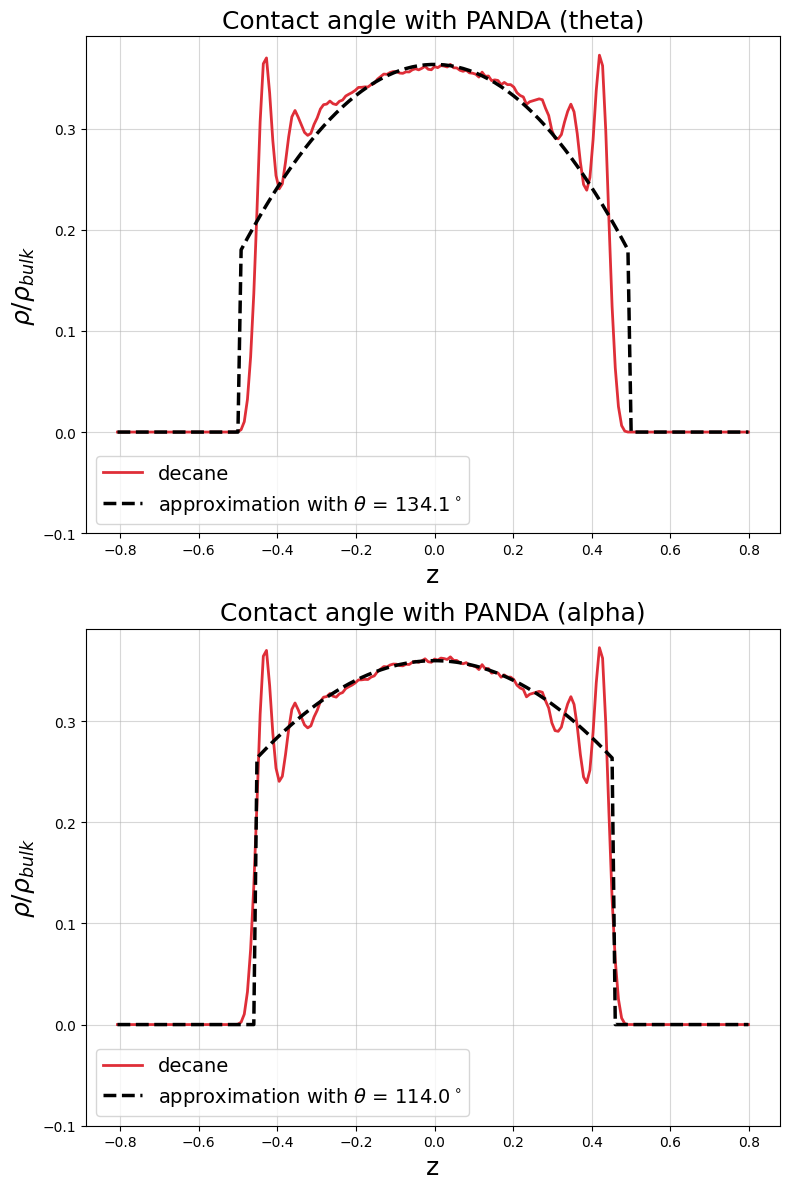

In [11]:
# Visualisation of density profile with different PANDA algorithm version

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

i = -1

ax1.grid(alpha=0.5)
ax1.plot(
    normalized_axises[i, :], normalized_denses[i, :],
    label='decane',
    color='#DF2E38',
    linewidth=2
)

rho_theta = getattr(src.utils_py.interface, f"rho_{interface_type}_theta")

ax1.plot(
    normalized_axises[i, :], rho_theta(normalized_axises[i, :], l, phi, angles_theta[i]),
    label=r'approximation with $\theta$ = {:.1f}$^\circ$'.format(np.rad2deg(angles_theta[i])),
    color='#000000',
    linewidth=2.5,
    linestyle='dashed'
)

ax2.grid(alpha=0.5)
ax2.plot(
    normalized_axises[i, :], normalized_denses[i, :],
    label='decane',
    color='#DF2E38',
    linewidth=2
)

rho_alpha = getattr(src.utils_py.interface, f"rho_{interface_type}_alpha")

ax2.plot(
    normalized_axises[i, :], rho_alpha(normalized_axises[i, :], l, phi, angles_alpha[i], delta_alpha[i]),
    label=r'approximation with $\theta$ = {:.1f}$^\circ$'.format(np.rad2deg(angles_alpha[i])),
    color='#000000',
    linewidth=2.5,
    linestyle='dashed'
)


ax1.set_title('Contact angle with PANDA (theta)', fontsize=18)
ax2.set_title('Contact angle with PANDA (alpha)', fontsize=18)
ax1.set_ylim(bottom=-0.1)
ax2.set_ylim(bottom=-0.1)
ax1.set_xlabel('z', fontsize=18)
ax1.set_ylabel(r'$\rho / \rho_{bulk}$', fontsize=18)
ax1.legend(loc='best', fontsize=14)

ax2.set_xlabel('z', fontsize=18)
ax2.set_ylabel(r'$\rho / \rho_{bulk}$', fontsize=18)
ax2.legend(loc='best', fontsize=14)


plt.tight_layout()
plt.show()

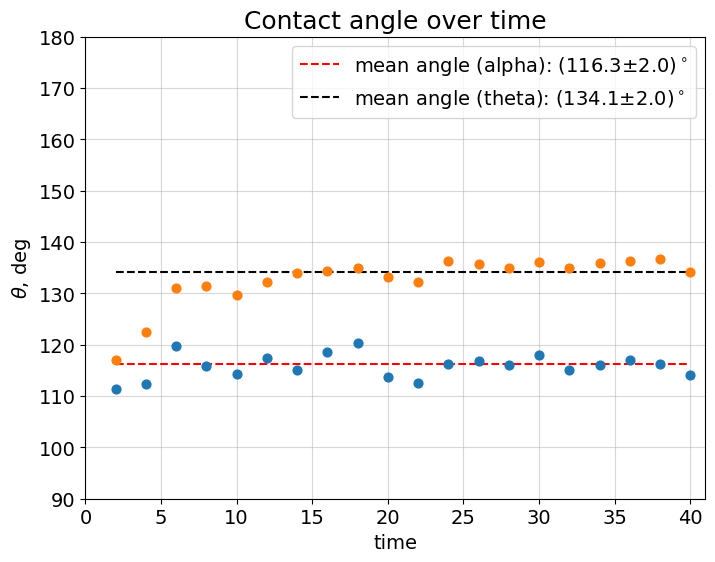

In [12]:
# Visualisation of contact angle over time

plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5, zorder=1)

# Alpha
# t = np.arange(2, 41, 4, dtype=int)
t = np.linspace(0, 40, len(angles_alpha)+1, endpoint=True)[1:]
plt.scatter(t, np.rad2deg(angles_alpha), s=40, zorder=3)

begin_alpha = 2
mean_angle = np.mean(np.rad2deg(angles_alpha)[begin_alpha:])
std_angle = np.std(np.rad2deg(angles_alpha)[begin_alpha:])
plt.hlines(
    mean_angle,
    t[0], t[-1],
    color='red',
    zorder=2,
    linestyles="--",
    label=r"mean angle (alpha): ({:.1f}$\pm${:.1f})$^\circ$".format(mean_angle, std_angle)
)

# Theta
plt.scatter(t, np.rad2deg(angles_theta), s=40, zorder=3)

begin_theta = 2
mean_angle = np.mean(np.rad2deg(angles_theta)[begin_theta:])
std_angle = np.std(np.rad2deg(angles_theta)[begin_theta:])
plt.hlines(
    mean_angle,
    t[0], t[-1],
    color='black',
    zorder=2,
    linestyles="--",
    label=r"mean angle (theta): ({:.1f}$\pm${:.1f})$^\circ$".format(mean_angle, std_angle)
)

plt.title('Contact angle over time', fontsize=18)
plt.xlim(0, 41)
plt.ylim(90, 180)
plt.xlabel('time', fontsize=14)
plt.ylabel(r'$\theta$, deg', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

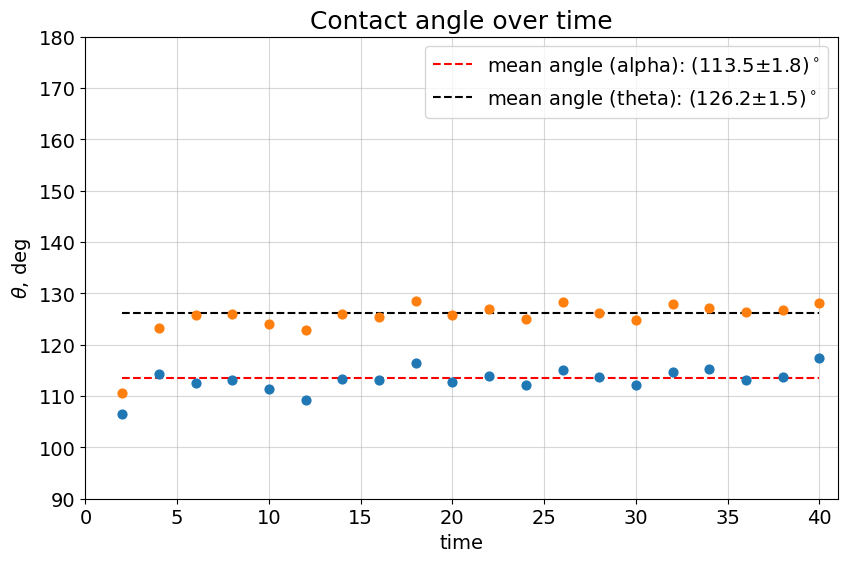

In [24]:
# Visualisation of contact angle over time

# plt.figure(figsize=(8, 6))
golden_ratio = (1 + np.sqrt(5)) / 2
fig, ax = plt.subplots(figsize=(6 * golden_ratio, 6))
plt.grid(alpha=0.5, zorder=1)

# Alpha
# t = np.arange(2, 41, 4, dtype=int)
t = np.linspace(0, 40, len(angles_alpha)+1, endpoint=True)[1:]
plt.scatter(t, np.rad2deg(angles_alpha), s=40, zorder=3)

begin_alpha = 2
mean_angle = np.mean(np.rad2deg(angles_alpha)[begin_alpha:])
std_angle = np.std(np.rad2deg(angles_alpha)[begin_alpha:])
plt.hlines(
    mean_angle,
    t[0], t[-1],
    color='red',
    zorder=2,
    linestyles="--",
    label=r"mean angle (alpha): ({:.1f}$\pm${:.1f})$^\circ$".format(mean_angle, std_angle)
)

# Theta
plt.scatter(t, np.rad2deg(angles_theta), s=40, zorder=3)

begin_theta = 2
mean_angle = np.mean(np.rad2deg(angles_theta)[begin_theta:])
std_angle = np.std(np.rad2deg(angles_theta)[begin_theta:])
plt.hlines(
    mean_angle,
    t[0], t[-1],
    color='black',
    zorder=2,
    linestyles="--",
    label=r"mean angle (theta): ({:.1f}$\pm${:.1f})$^\circ$".format(mean_angle, std_angle)
)

plt.title('Contact angle over time', fontsize=18)
plt.xlim(0, 41)
plt.ylim(90, 180)
plt.xlabel('time', fontsize=14)
plt.ylabel(r'$\theta$, deg', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()